## Lesson3: Pytorchでクラス分類学習を行う
- いよいよモデルの学習実験
- モデルの学習手順は大方以下の繰り返し
    - Step1. イテレータでデータを読み出す
    - Step2. 定義したモデルにデータをインプットする
    - Step3. モデルのアウトプットをもとに誤差を計算し、モデルへ逆伝播

### まずはDatasetの作成から (Lesson1で使用したものと同じものを使います)

In [1]:
import os
from PIL import Image
Image.MAX_IMAGE_PIXELS = None # サイズ読み込みエラー対策のおまじない
import torch.utils.data # Datasetクラスを継承するのに使用
import torchvision.transforms as transforms # 画像の前処理に使用

class AntBee_Dataset(torch.utils.data.Dataset):
    def __init__(self, mode):
        super(torch.utils.data.Dataset, self).__init__() #torch.utils.data.Datasetの継承
        # Initialize setting
        self.mode = mode # trainモードかvalitationモードかの判定に使用(str型)
        self.src_root = 'hymenoptera_data' # ソース画像ディレクトリまでのpath
        self.transform = self._transform() # 画像前処理の関数
        # Get img paths and set label
        self.img_paths_list = []
        self.label_list = []
        self.label_dic = {}
        src_dir = os.path.join(self.src_root, mode)
        dir_list = os.listdir(src_dir)
        for idx,dir in enumerate(dir_list):
            # Resister label
            self.label_dic[idx] = dir # {0:ants, 1:bees}となるように代入
            # Get img paths
            img_list = os.listdir(os.path.join(src_dir, dir))
            for img_name in img_list:
                img_path = os.path.join(src_dir, dir, img_name)
                self.img_paths_list.append(img_path) # 画像ファイルまでのパスをappend
                self.label_list.append(idx) # label番号をappend
                
    def __len__(self): # ! Datasetをつくるにあたって必要 !
        return len(self.label_list)
    
    def __getitem__(self, index): # ! Dataloaderで読みだすのに必要 !
        # Read img path & label
        img_path = self.img_paths_list[index]
        label = self.label_list[index]
        # Load img and proceed
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        # 辞書型でreturn
        # img: Tensor型の画像データ(ch, h, w)
        return {'img':img, 'label':label, 'name':self.label_dic[label]}
        
    def _transform(self): # 画像データの前処理に
        transform = transforms.Compose([
            transforms.Resize((224, 224), Image.BICUBIC), # 画像のリサイズ (Image.BICUBICはリサイズ時の補完関数)
            transforms.ToTensor(), # 画像のピクセル値を正規化 [0, 255] -> [0, 1]
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # [0, 1] -> [-1, 1]の値をとるように正規化(標準正規分布)
        ])
        return transform

### 続いて学習モデルの定義
#### 構築イメージは以下の通り


In [2]:
import torch
import torch.nn as nn

class myNetwork(nn.Module):
    def __init__(self, input_ch=3, label_num=2, img_size=224):
        super(myNetwork, self).__init__()
        # 畳み込み処理部門
        self.conv0 = nn.Sequential(*[
            nn.Conv2d(input_ch, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        ])
        self.conv1 = nn.Sequential(*[
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1)
        ])
        # 線形関数でラベル分類内容をアウトプットする部門
        img_resize = img_size // (2**3)
        self.linear0 = nn.Linear(img_resize*img_resize*256, label_num)
        
    def forward(self, input):
        # 畳み込み処理部門に突っ込むデータ
        x = self.conv0(input)
        x = self.conv1(x) # -> データの形式は [B, C, H, W]
        # 線形関数でラベル分類内容をアウトプットする部門に突っ込むデータ
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3)) # -> データの形式を [B, C*H*W]に変換する
        x = self.linear0(x)
        return x

### データ・モデルの準備ができたら次は「学習」のための下準備

In [5]:
import torch.optim as optim # <- 最適化関数を呼ぶ
from torch.autograd import Variable # <- 計算グラフ構築機能を持たせるのにつかう

model = myNetwork(input_ch=3, label_num=2, img_size=224) # <- モデルインスタンスの作成, 今回はカラー画像(ch=3)で244×244リサイズ(img_size=244)したアリ&ハチ(label_num=2)画像データセットを対象に学習
model.train()
opt = optim.Adam(model.parameters()) # <- モデルに適用させる最適化関数の定義
criterion = nn.CrossEntropyLoss() # <- pytorchで用意してくれている誤差関数の定義 ※自分のオリジナルも作れる

### 大方準備はできたので、まずは1epoch分の学習をみてみよう
#### Step1. イテレータでデータを読み出す
#### Step2. 定義したモデルにデータをインプットする
#### Step3. モデルのアウトプットをもとに誤差を計算し、モデルへ逆伝播

In [4]:
train_data = AntBee_Dataset(mode='train')
train_loader = torch.utils.data.DataLoader(dataset= train_data, batch_size=5, shuffle=True)

# まずは 1epoch
for i, data in enumerate(train_loader):
    #------------------Step1------------------
    imgs, labels = data['img'], data['label']
    imgs = Variable(imgs)
    labels = Variable(labels)
    #-----------------------------------------
    #------------------Step2------------------
    output = model(imgs)
    #-----------------------------------------
    #------------------Step3------------------
    loss = criterion(output, labels)

    opt.zero_grad() # <- 前の勾配情報をいったん0にする
    loss.backward() # <- 逆伝播
    opt.step() # <- モデルのパラメータ更新
    #-----------------------------------------

### ちょっと解説
#### ・output = model(imgs)の中身とは？
##### インプットされた画像が、「アリ」か「ハチ」かどちらかの推定度を出している → outputのsizeは [B, Class_Num]
#### ・loss は何を計算している？
##### 交差エントロピーと呼ばれる、正解とモデルの予測がどれだけ近いかを近似するもの
$$
    \mathrm{E}(x)= -\sum_{k}q(k)log(p(k))
$$
##### p(k)は推定したデータと正解データが同じになる確率で、q(k)は教師データの確率
##### 例えば、p(k)=[0.5, 0.5]で q(k)=[1.0, 0.0]の時。つまり「アリ」を推測してもらいたかったのに、モデルがアリ=0.5, ハチ=0.5と中途半端に推測してしまった場合
$$
    \mathrm{E}(x) = -\sum_{k}q(k)log(p(k)) \\ = -(1.0*log(0.5) + 0.0*log(0.5)) \fallingdotseq 0.301
$$
#### ・すなわち、クラス分類学習用のモデルの目的は「交差エントロピーを0に近づけるように、パラメータを調整する」ことにある

### コードをいじっていろいろ可視化してみよう
#### さきほどのコードだとモデルの推定度がどれだけ当たっているかが分からない
#### 1イテレータのデータで、outputの中身や正答率の計算をしてみよう

In [6]:
data = iter(train_loader).next()
imgs, labels = data['img'], data['label']
imgs, labels = Variable(imgs), Variable(labels)

output = model(imgs)
# outputの中身の可視化
print("output = \n{}".format(output)) # <- 勾配情報とかもついてくる
print("output(only data) = \n{}".format(output.data)) # <- アウトプットの値だけ取り出したい場合はこちら

# outputの内容から正答率を計算
model_answer = output.max(1) # 配列dim=1(1行目)を基準に0列目,1列目のどちらが高い値をとっているか
print("model predict = \n{}".format(model_answer)) # <- 各行のmax値と該当列番号を返す
model_answer = model_answer[1] # <- 該当列番号を呼ぶならこちら (※ホントは model_answer=output.max(1)[1]で呼べる)

accu_num = (model_answer == labels).sum() # <- 正解列が一致している数を数える
print("model predict (only indice) = \n{}".format(model_answer))
print("target predict = \n{}".format(labels.data))
print("answer num = {}".format(accu_num.data))

output = 
tensor([[ 24.1924, -24.7204],
        [  6.3879,  -6.6907],
        [ 13.0476, -13.2994],
        [ 47.7290, -48.4261],
        [ 33.9422, -34.9765]], grad_fn=<AddmmBackward>)
output(only data) = 
tensor([[ 24.1924, -24.7204],
        [  6.3879,  -6.6907],
        [ 13.0476, -13.2994],
        [ 47.7290, -48.4261],
        [ 33.9422, -34.9765]])
model predict = 
torch.return_types.max(
values=tensor([24.1924,  6.3879, 13.0476, 47.7290, 33.9422], grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 0, 0]))
model predict (only indice) = 
tensor([0, 0, 0, 0, 0])
target predict = 
tensor([1, 1, 1, 0, 0])
answer num = 2


### 学習している様子がわかるコードを書いてみる
#### ここまで学習ステップの書き方や、lossの値や正答率の可視化を書いたのでこれらをフルに活用して、モデルが学習している様子を見てみよう
##### CPUだと出力までが遅いかも 

In [7]:
train_data = AntBee_Dataset(mode='train')
train_loader = torch.utils.data.DataLoader(dataset= train_data, batch_size=5, shuffle=True)

for epoch in range(10):
    train_loss = 0.0
    train_accu = 0.0
    for i, data in enumerate(train_loader):
        #------------------Step1------------------
        imgs, labels = data['img'], data['label']
        imgs = Variable(imgs)
        labels = Variable(labels)
        #-----------------------------------------
        #------------------Step2------------------
        output = model(imgs)
        #-----------------------------------------
        #------------------Step3------------------
        loss = criterion(output, labels)

        opt.zero_grad() # <- 前の勾配情報をいったん0にする
        loss.backward() # <- 逆伝播
        opt.step() # <- モデルのパラメータ更新
        #-----------------------------------------
        #--------Calc Acuuracy & Loss ------------
        # Loss
        train_loss += loss.data
        # Accuracy
        train_accu += (output.max(1)[1] == labels).sum().data
        #-----------------------------------------
    # 加算されていったtrain_loss, predict_accuの平均を計算 -> これをモデルの正解率やLossの具合とする
    train_loss = train_loss / len(train_loader.dataset)
    train_accu = train_accu / len(train_loader.dataset)
    print('Epoch:{} Loss:{} Accuracy:{}'.format(epoch, train_loss, train_accu*100))

Epoch:0 Loss:2.02359676361084 Accuracy:58.775508880615234
Epoch:1 Loss:1.5758631229400635 Accuracy:58.367347717285156
Epoch:2 Loss:1.3957387208938599 Accuracy:61.632652282714844
Epoch:3 Loss:0.9637519121170044 Accuracy:68.9795913696289
Epoch:4 Loss:1.948944091796875 Accuracy:64.08163452148438
Epoch:5 Loss:2.5714123249053955 Accuracy:64.48979187011719
Epoch:6 Loss:5.783422470092773 Accuracy:66.12245178222656
Epoch:7 Loss:3.370915174484253 Accuracy:72.24490356445312
Epoch:8 Loss:1.8632469177246094 Accuracy:75.51020050048828
Epoch:9 Loss:0.8046930432319641 Accuracy:82.85714721679688


### 学習したモデルをセーブしよう

In [6]:
torch.save(model.state_dict(), 'myModel.pth') # <- 別に.pthをつけなくても保存はできる

### 学習したモデルを使って、テストに掛けよう

In [7]:
model.load_state_dict(torch.load('myModel.pth'))
model.eval() # <- 評価用なのでevalモード

myNetwork(
  (conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (linear0): Linear(in_features=200704, out_features=2, bias=True)
)

In [18]:
val_data = AntBee_Dataset(mode='val')
val_loader = torch.utils.data.DataLoader(dataset= val_data, batch_size=5, shuffle=False)

test_accu = 0.0
test_loss = 0.0
for data in val_loader:
    imgs, labels = data['img'], data['label']
    imgs, labels = Variable(imgs), Variable(labels)
    
    with torch.no_grad():# <- 勾配のトラッキングをoffにする
        output = model(imgs)
        loss = criterion(output, labels)
        
        test_loss += loss.data
        test_accu += (output.max(1)[1]==labels).sum().data
        
test_loss = test_loss / len(val_loader.dataset)
test_accu = test_accu / len(val_loader.dataset)
print('Eval Loss:{} Accuracy:{}'.format(test_loss, test_accu*100))

Eval Loss:5.955887317657471 Accuracy:54.24836730957031


### 図と一緒に結果の可視化

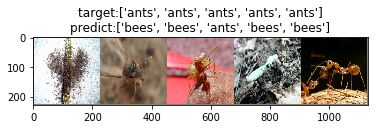

In [21]:
val_data = AntBee_Dataset(mode='val')
val_loader = torch.utils.data.DataLoader(dataset= val_data, batch_size=5, shuffle=False)
data = iter(val_loader).next()
imgs, answer_labels = data['img'], data['label']
imgs, answer_labels = Variable(imgs), Variable(answer_labels)

with torch.no_grad():
    output = model(imgs)
    predict_labels = output.max(1)[1]
    
predict_answer = [val_data.label_dic[label] for label in predict_labels.numpy()] # (Tensor型Data).numpy()でnumpy型のデータに変換
target_answer = [val_data.label_dic[label] for label in answer_labels.numpy()]

# 画像の可視化と予測の表示
import matplotlib.pyplot as plt
import torchvision

img_grid = torchvision.utils.make_grid(imgs).numpy()
img_grid = img_grid.transpose((1, 2, 0))
img_grid = 0.5*img_grid + 0.5
plt.imshow(img_grid)
title = 'target:{}\npredict:{}'.format(target_answer, predict_answer)
plt.title(title)
plt.pause(0.001)

# 演習問題
## Q1. valデータセットでテストを掛けてうまく学習できたか評価しよう (「過学習」が起こったか、「未学習」が起こったか)
## Q2. 前回の演習問題に出てきたモデルをつかって学習を行わせよう
## Q3. エポック数を増やしたり、モデルの構造を変えたりして学習してみよう